In [164]:
import numpy as np
import csv
import pandas as pd
import re
import json
import string
import copy
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt          # plotting
%matplotlib inline

In [2]:
wiki = pd.read_csv('Week_2/people_wiki.csv')
with open('Week_2/people_wiki_map_index_to_word.json') as f:
    map_index_to_words = json.load(f)

    

In [3]:
def norm(x):
    sum_sq = x.dot(x.T)
    norm = np.sqrt(sum_sq)
    return (norm)

def remove_punctuation(text):
    trans = str.maketrans('','',string.punctuation)
    return text.translate(trans) 

def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    
    return csr_matrix( (data, indices, indptr), shape)

def generate_random_vectors(num_vector, dim):
    return np.random.randn(dim, num_vector)
    

In [5]:
corpus = load_sparse_csr('Week_2/people_wiki_tf_idf.npz')

In [117]:
corpus[0,:]

<1x547979 sparse matrix of type '<class 'numpy.float64'>'
	with 139 stored elements in Compressed Sparse Row format>

In [6]:
# Generate 3 random vectors of dimension 5, arranged into a single 5 x 3 matrix.
np.random.seed(0) # set seed=0 for consistent results
print (generate_random_vectors(num_vector=3, dim=5))

[[ 1.76405235  0.40015721  0.97873798]
 [ 2.2408932   1.86755799 -0.97727788]
 [ 0.95008842 -0.15135721 -0.10321885]
 [ 0.4105985   0.14404357  1.45427351]
 [ 0.76103773  0.12167502  0.44386323]]


In [7]:
np.random.seed(0)
random_vectors = generate_random_vectors(num_vector=16, dim=547979)
print (random_vectors.shape)

(547979, 16)


In [139]:
doc = corpus[0, :] # vector of tf-idf values for document 0
print(doc.shape)
print (doc.dot(random_vectors[:, 0]) >= 0) # True if positive sign; False if negative sign
print (doc.dot(random_vectors[:, 1]) >= 0)  # True if positive sign; False if negative sign

(1, 547979)
[ True]
[ True]


In [10]:
print (doc.dot(random_vectors) >= 0) # should return an array of 16 True/False bits
print (np.array(doc.dot(random_vectors) >= 0, dtype=int)) # display index bits in 0/1's

[[ True  True False False False  True  True False  True  True  True False
  False  True False  True]]
[[1 1 0 0 0 1 1 0 1 1 1 0 0 1 0 1]]


In [11]:
print (corpus[0:2].dot(random_vectors) >= 0) # compute bit indices of first two documents
print (corpus.dot(random_vectors) >= 0) # compute bit indices of ALL documents

[[ True  True False False False  True  True False  True  True  True False
  False  True False  True]
 [ True False False False  True  True False  True  True False  True False
   True False False  True]]
[[ True  True False ...  True False  True]
 [ True False False ... False False  True]
 [False  True False ...  True False  True]
 ...
 [ True  True False ...  True  True  True]
 [False  True  True ...  True False  True]
 [ True False  True ... False False  True]]


In [12]:
doc = corpus[0, :]  # first document
index_bits = (doc.dot(random_vectors) >= 0)
powers_of_two = (1 << np.arange(15, -1, -1))
print (index_bits)
print (powers_of_two)          # [32768, 16384, 8192, 4096, 2048, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2, 1]
print (index_bits.dot(powers_of_two))

[[ True  True False False False  True  True False  True  True  True False
  False  True False  True]]
[32768 16384  8192  4096  2048  1024   512   256   128    64    32    16
     8     4     2     1]
[50917]


In [118]:
## This array gives us the integer index of the bins for all documents.
index_bits = corpus.dot(random_vectors) >= 0
print (index_bits.dot(powers_of_two).shape)

(59071,)


In [144]:
"""
Now we are ready to complete the following function. 
Given the integer bin indices for the documents, you should compile a list of document IDs that belong to each bin. 
Since a list is to be maintained for each unique bin index, a dictionary of lists is used.

1. Compute the integer bin indices. This step is already completed. 

2. For each document in the dataset, do the following: 

Get the integer bin index for the document. 
Fetch the list of document ids associated with the bin; if no list yet exists for this bin, assign the bin an empty list. 
Add the document id to the end of the list. 

"""
def train_lsh(data, num_vector=16, seed=None):
    
    dim = data.shape[1]
    if seed is not None:
        np.random.seed(seed)
    random_vectors = generate_random_vectors(num_vector, dim)
  
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
  
    table = {}
    
    # Partition data points into bins
    bin_index_bits = (data.dot(random_vectors) >= 0)
  
    # Encode bin index bits into integers
    bin_indices = bin_index_bits.dot(powers_of_two)
    
    # Update `table` so that `table[i]` is the list of document ids with bin index equal to i.
    for data_index, bin_index in enumerate(bin_indices):
        if bin_index not in table:
            # If no list yet exists for this bin, assign the bin an empty list.
            table[bin_index] = [] # YOUR CODE HERE
        # Fetch the list of document ids associated with the bin and add the document id to the end.
        table[bin_index].append(data_index)# YOUR CODE HERE

    model = {'data': data,
             'bin_index_bits': bin_index_bits,
             'bin_indices': bin_indices,
             'table': table,
             'random_vectors': random_vectors,
             'num_vector': num_vector}
    
    return model

In [145]:
model = train_lsh(corpus, num_vector=16, seed=143)
table = model['table']
if   0 in table and table[0]   == [39583] and \
   143 in table and table[143] == [19693, 28277, 29776, 30399]:
    print ('Passed!')
else:
    print ('Check your code.')

Passed!


In [18]:
print (wiki[wiki['name'] == 'Barack Obama'])

                                              URI          name  \
35817  <http://dbpedia.org/resource/Barack_Obama>  Barack Obama   

                                                    text  
35817  barack hussein obama ii brk husen bm born augu...  


In [142]:
Obama_doc = corpus[35817,:]
print(Obama_doc.shape)
Obama_index_bits = (Obama_doc.dot(model['random_vectors']) >= 0)
powers_of_two = (1 << np.arange(15, -1, -1))
print (Obama_index_bits)
print (powers_of_two)          # [32768, 16384, 8192, 4096, 2048, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2, 1]
print (Obama_index_bits.dot(powers_of_two))

(1, 547979)
[[ True  True False False False  True False False False False False  True
  False False  True False]]
[32768 16384  8192  4096  2048  1024   512   256   128    64    32    16
     8     4     2     1]
[50194]


In [196]:
print(sum(model['bin_index_bits'][35817] == model['bin_index_bits'][24478]))
print(model['bin_indices'][35817])

14
370245


Quiz Question. What is the document id of Barack Obama's article?
ANS: 35817

Quiz Question. Which bin contains Barack Obama's article? Enter its integer index. 
ANS: 50194




In [192]:
print (wiki[wiki['name'] == 'Joe Biden'])
Biden_doc = corpus[24478,:]
Biden_index_bits = (Biden_doc.dot(model['random_vectors']) >= 0)
powers_of_two = (1 << np.arange(15, -1, -1))
print (Biden_index_bits)
print (powers_of_two)          # [32768, 16384, 8192, 4096, 2048, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2, 1]
print (Biden_index_bits.dot(powers_of_two))

                                           URI       name  \
24478  <http://dbpedia.org/resource/Joe_Biden>  Joe Biden   

                                                    text     id  
24478  joseph robinette joe biden jr dosf rbnt badn b...  24478  
[[ True False False  True  True False  True False  True  True False False
   True False False False  True False False]]
[32768 16384  8192  4096  2048  1024   512   256   128    64    32    16
     8     4     2     1]


ValueError: shapes (1,19) and (16,) not aligned: 19 (dim 1) != 16 (dim 0)

In [193]:
print (Obama_index_bits.flatten() == Biden_index_bits.flatten())
print(sum(Obama_index_bits.flatten() == Biden_index_bits.flatten()))

False


TypeError: 'bool' object is not iterable

Recall from the previous assignment that Joe Biden was a close neighbor of Barack Obama. 

Quiz Question. Examine the bit representations of the bins containing Barack Obama and Joe Biden. In how many places do they agree?
ANS: 14

Compare the result with a former British diplomat, whose bin representation agrees with Obama's in only 8 out of 16 places.

In [148]:
print (wiki[wiki['name']=='Wynn Normington Hugh-Jones'])

print (np.array(model['bin_index_bits'][22745], dtype=int)) # list of 0/1's
print (model['bin_index_bits'][35817] == model['bin_index_bits'][22745])

                                                     URI  \
22745  <http://dbpedia.org/resource/Wynn_Normington_H...   

                             name  \
22745  Wynn Normington Hugh-Jones   

                                                    text  
22745  sir wynn normington hughjones kb sometimes kno...  
[0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0]
[False False  True False  True False False  True  True  True False  True
  True False False  True]


In [28]:
print (model['table'][model['bin_indices'][35817]])

[21426, 35817, 39426, 50261, 53937]


In [35]:
doc_ids = list(model['table'][model['bin_indices'][35817]])
doc_ids.remove(35817) # display documents other than Obama

docs = wiki.iloc[doc_ids]
print(docs['name'])
print ("It turns out that Joe Biden is much closer to Barack Obama than any of the four documents, even though Biden's bin representation differs from Obama's by 2 bits.")

21426              Mark Boulware
39426    John Wells (politician)
50261          Francis Longstaff
53937      Madurai T. Srinivasan
Name: name, dtype: object
It turns out that Joe Biden is much closer to Barack Obama than any of the four documents, even though Biden's bin representation differs from Obama's by 2 bits.


In [149]:
def cosine_distance(x, y):
    xy = x.dot(y.T)
    dist = xy/(norm(x)*norm(y))
    return 1-dist[0,0]

obama_tf_idf = corpus[35817,:]
biden_tf_idf = corpus[24478,:]

print ('================= Cosine distance from Barack Obama')
print ('Barack Obama - {0:24s}: {1:f}'.format('Joe Biden',
                                             cosine_distance(obama_tf_idf, biden_tf_idf)))
for doc_id in doc_ids:
    doc_tf_idf = corpus[doc_id,:]
    print ('Barack Obama - {}: {}'.format(wiki.iloc[doc_id]['name'], cosine_distance(obama_tf_idf, doc_tf_idf)))

================= Cosine distance from Barack Obama
Barack Obama - Joe Biden               : 0.703139
Barack Obama - Mark Boulware: 0.9508667575252789
Barack Obama - John Wells (politician): 0.975966004109956
Barack Obama - Francis Longstaff: 0.9782561630406376
Barack Obama - Madurai T. Srinivasan: 0.9930921484244789


Moral of the story. Similar data points will in general tend to fall into nearby bins, but that's all we can say about LSH. In a high-dimensional space such as text features, we often get unlucky with our selection of only a few random vectors such that dissimilar data points go into the same bin while similar data points fall into different bins. Given a query document, we must consider all documents in the nearby bins and sort them according to their actual distances from the query.

1. Let L be the bit representation of the bin that contains the query documents.
2. Consider all documents in bin L.
3. Consider documents in the bins whose bit representation differs from L by 1 bit.
4. Consider documents in the bins whose bit representation differs from L by 2 bits.

To obtain candidate bins that differ from the query bin by some number of bits, we use itertools.combinations, which produces all possible subsets of a given list. See this documentation for details.
1. Decide on the search radius r. This will determine the number of different bits between the two vectors.
2. For each subset (n_1, n_2, ..., n_r) of the list [0, 1, 2, ..., num_vector-1], do the following:
   * Flip the bits (n_1, n_2, ..., n_r) of the query bin to produce a new bit vector.
   * Fetch the list of documents belonging to the bin indexed by the new bit vector.
   * Add those documents to the candidate set.

In [90]:
from itertools import combinations

num_vector = 16
search_radius = 0
trynerr = [1,2,3,4,5]
for diff in combinations(range(num_vector), search_radius):
    print (diff)
    print(1)
    

()
1


In [152]:
def search_nearby_bins(query_bin_bits, table, search_radius=2, initial_candidates=set()):
    """
    For a given query vector and trained LSH model, return all candidate neighbors for
    the query among all bins within the given search radius.
    
    Example usage
    -------------
    >>> model = train_lsh(corpus, num_vector=16, seed=143)
    >>> q = model['bin_index_bits'][0]  # vector for the first document
  
    >>> candidates = search_nearby_bins(q, model['table'])
    """
    num_vector = len(query_bin_bits)
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
    
    # Allow the user to provide an initial set of candidates.
    candidate_set = initial_candidates.copy()
    
    for different_bits in combinations(range(num_vector), search_radius):       
        # Flip the bits (n_1,n_2,...,n_r) of the query bin to produce a new bit vector.
        ## Hint: you can iterate over a tuple like a list
        alternate_bits = query_bin_bits.copy()
        
        for i in different_bits:
            alternate_bits[i] = not query_bin_bits[i] # YOUR CODE HERE 
        
        # Convert the new bit vector to an integer index
        nearby_bin = alternate_bits.dot(powers_of_two)
       
        # Fetch the list of documents belonging to the bin indexed by the new bit vector.
        # Then add those documents to candidate_set
        # Make sure that the bin exists in the table!
        # Hint: update() method for sets lets you add an entire list to the set
        if nearby_bin in table:
            candidate_set.update(table[nearby_bin]) # YOUR CODE HERE: Update candidate_set with the documents in this bin.
            
    return candidate_set

In [153]:
import types
import weakref
from copyreg import dispatch_table

In [154]:
obama_bin_index = model['bin_index_bits'][35817] # bin index of Barack Obama

candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=0)
if candidate_set == set([35817, 21426, 53937, 39426, 50261]):
    print ('Passed test')
else:
    print(candidate_set)
    print ('Check your code')
print ('List of documents in the same bin as Obama: 35817, 21426, 53937, 39426, 50261')

Passed test
List of documents in the same bin as Obama: 35817, 21426, 53937, 39426, 50261


In [155]:
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=1, initial_candidates=candidate_set)
if candidate_set == set([39426, 38155, 38412, 28444, 9757, 41631, 39207, 59050, 47773, 53937, 21426, 34547,
                         23229, 55615, 39877, 27404, 33996, 21715, 50261, 21975, 33243, 58723, 35817, 45676,
                         19699, 2804, 20347]):
    print ('Passed test')
else:
    print(candidate_set)
    print(len(candidate_set))
    print ('Check your code')

Passed test


In [177]:
def query(vec, model, k, max_search_radius):
  
    data = model['data']
    table = model['table']
    random_vectors = model['random_vectors']
    num_vector = random_vectors.shape[1]
    
    
    # Compute bin index for the query vector, in bit representation.
    bin_index_bits = (vec.dot(random_vectors) >= 0).flatten()
    
    # Search nearby bins and collect candidates
    candidate_set = set()
    for search_radius in range(max_search_radius+1):
        candidate_set = search_nearby_bins(bin_index_bits, table, search_radius, initial_candidates=candidate_set)
    
    # Sort candidates by their true distances from the query
    nearest_neighbors = pd.DataFrame({'id' : list(candidate_set)})
    candidates = data[np.array(list(candidate_set)),:]
    nearest_neighbors['distance'] = pairwise_distances(candidates, vec, metric='cosine').flatten()
    
    return nearest_neighbors.sort_values(by=['distance'], ascending=True)[:k],len(candidate_set)

In [178]:
print (query(corpus[35817,:], model, k=10, max_search_radius=3))

(        id  distance
369  35817  0.000000
704  24478  0.703139
267  56008  0.856848
132  37199  0.874669
515  40353  0.890034
390   9267  0.898377
228  55909  0.899340
359   9165  0.900921
229  57958  0.903003
269  49872  0.909533, 727)


In [179]:
wiki['id'] = wiki.index
#wiki['id'].astype(str).astype(int)

In [180]:
wiki[['id', 'name']]

,id,name
0,0,Digby Morrell
1,1,Alfred J. Lewy
2,2,Harpdog Brown
3,3,Franz Rottensteiner
4,4,G-Enka
...,...,...
59066,59066,Olari Elts
59067,59067,Scott F. Crago
59068,59068,David Cass (footballer)
59069,59069,Keith Elias


In [181]:
result, num_candidates_considered = query(corpus[35817,:], model, k=10, max_search_radius=3)
print (num_candidates_considered)
result['id']

727


369    35817
704    24478
267    56008
132    37199
515    40353
390     9267
228    55909
359     9165
229    57958
269    49872
Name: id, dtype: int64

In [182]:
pd.merge(result, wiki[['id', 'name']], how='inner', on='id').sort_values(by=['distance'])

,id,distance,name
0,35817,0.000000,Barack Obama
1,24478,0.703139,Joe Biden
2,56008,0.856848,Nathan Cullen
3,37199,0.874669,Barry Sullivan (lawyer)
4,40353,0.890034,Neil MacBride
5,9267,0.898377,Vikramaditya Khanna
6,55909,0.899340,Herman Cain
7,9165,0.900921,Raymond F. Clevenger
8,57958,0.903003,Michael J. Malbin
9,49872,0.909533,Lowell Barron


Effect of nearby bin search
How does nearby bin search affect the outcome of LSH? There are three variables that are affected by the search radius:

1. Number of candidate documents considered
2. Query time
3. Distance of approximate neighbors from the query

Let us run LSH multiple times, each with different radii for nearby bin search. We will measure the three variables as discussed above.

In [183]:
num_candidates_history = []
query_time_history = []
max_distance_from_query_history = []
min_distance_from_query_history = []
average_distance_from_query_history = []
import time

for max_search_radius in range(17):
    start=time.time()
    # Perform LSH query using Barack Obama, with max_search_radius
    result, num_candidates = query(corpus[35817,:], model, k=10,
                                   max_search_radius=max_search_radius)
    end=time.time()
    query_time = end-start  # Measure time
    
    print ('Radius:', max_search_radius)
    # Display 10 nearest neighbors, along with document ID and name
    print (result.merge(wiki[['id', 'name']], how='inner', on='id').sort_values(by=['distance']))
    
    # Collect statistics on 10 nearest neighbors
    average_distance_from_query = result['distance'][1:].mean()
    max_distance_from_query = result['distance'][1:].max()
    min_distance_from_query = result['distance'][1:].min()
    
    num_candidates_history.append(num_candidates)
    query_time_history.append(query_time)
    average_distance_from_query_history.append(average_distance_from_query)
    print(average_distance_from_query)
    max_distance_from_query_history.append(max_distance_from_query)
    min_distance_from_query_history.append(min_distance_from_query)

Radius: 0
      id  distance                     name
0  35817  0.000000             Barack Obama
1  21426  0.950867            Mark Boulware
2  39426  0.975966  John Wells (politician)
3  50261  0.978256        Francis Longstaff
4  53937  0.993092    Madurai T. Srinivasan
0.9745452682750878
Radius: 1
      id  distance                                   name
0  35817  0.000000                           Barack Obama
1  41631  0.947459                            Binayak Sen
2  21426  0.950867                          Mark Boulware
3  33243  0.951766                        Janice Lachance
4  33996  0.960859                            Rufus Black
5  28444  0.961081                       John Paul Phelan
6  20347  0.974130                        Gianni De Fraja
7  39426  0.975966                John Wells (politician)
8  34547  0.978215  Nathan Murphy (Australian politician)
9  50261  0.978256                      Francis Longstaff
0.9642887060258674
Radius: 2
      id  distance            

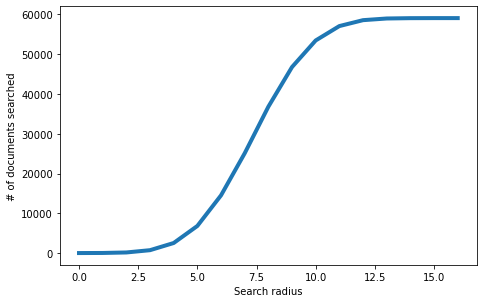

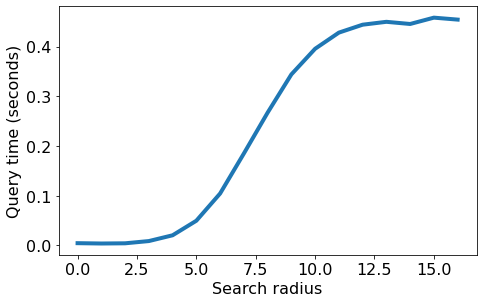

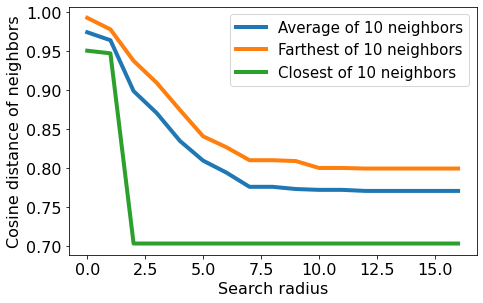

In [184]:

plt.figure(figsize=(7,4.5))
plt.plot(num_candidates_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('# of documents searched')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(query_time_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(average_distance_from_query_history, linewidth=4, label='Average of 10 neighbors')
plt.plot(max_distance_from_query_history, linewidth=4, label='Farthest of 10 neighbors')
plt.plot(min_distance_from_query_history, linewidth=4, label='Closest of 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance of neighbors')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

Some observations:

As we increase the search radius, we find more neighbors that are a smaller distance away.
With increased search radius comes a greater number documents that have to be searched. Query time is higher as a consequence.
With sufficiently high search radius, the results of LSH begin to resemble the results of brute-force search.

In [185]:

print('the smallest search radius that yielded the correct nearest neighbor, namely Joe Biden is 2')

the smallest search radius that yielded the correct nearest neighbor, namely Joe Biden is 2


In [186]:
print('the smallest search radius for Barack Obama that produced an average distance of 0.78 or bette is 11')

the smallest search radius for Barack Obama that produced an average distance of 0.78 or bette is 11


In [187]:
def brute_force_query(vec, data, k):
    num_data_points = data.shape[0]
    
    # Compute distances for ALL data points in training set
    nearest_neighbors = pd.DataFrame({'id':range(num_data_points)})
    nearest_neighbors['distance'] = pairwise_distances(data, vec, metric='cosine').flatten()
    
    return nearest_neighbors.sort_values(by=['distance'], ascending=True)[:k]

In [188]:
max_radius = 17
precision = {i:[] for i in range(max_radius)}
average_distance  = {i:[] for i in range(max_radius)}
query_time  = {i:[] for i in range(max_radius)}

np.random.seed(0)
num_queries = 10
for i, ix in enumerate(np.random.choice(corpus.shape[0], num_queries, replace=False)):
    print('%s / %s' % (i, num_queries))
    ground_truth = set(brute_force_query(corpus[ix,:], corpus, k=25)['id'])
    # Get the set of 25 true nearest neighbors
    
    for r in range(1,max_radius):
        start = time.time()
        result, num_candidates = query(corpus[ix,:], model, k=10, max_search_radius=r)
        end = time.time()

        query_time[r].append(end-start)
        # precision = (# of neighbors both in result and ground_truth)/10.0
        precision[r].append(len(set(result['id']) & ground_truth)/10.0)
        average_distance[r].append(result['distance'][1:].mean())

0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10


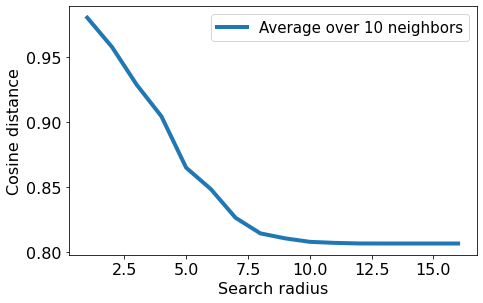

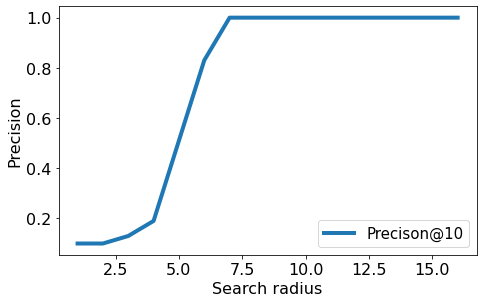

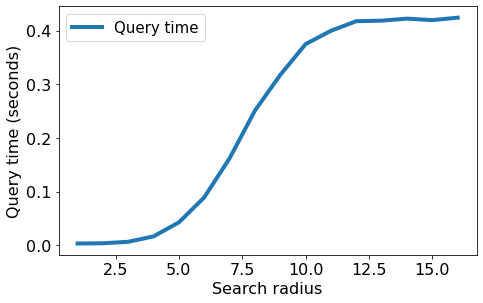

In [189]:
plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(average_distance[i]) for i in range(1,17)], linewidth=4, label='Average over 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(precision[i]) for i in range(1,17)], linewidth=4, label='Precison@10')
plt.xlabel('Search radius')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(query_time[i]) for i in range(1,17)], linewidth=4, label='Query time')
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [190]:
precision = {i:[] for i in range(5,20)}
average_distance  = {i:[] for i in range(5,20)}
query_time = {i:[] for i in range(5,20)}
num_candidates_history = {i:[] for i in range(5,20)}
ground_truth = {}

np.random.seed(0)
num_queries = 10
docs = np.random.choice(corpus.shape[0], num_queries, replace=False)

for i, ix in enumerate(docs):
    ground_truth[ix] = set(brute_force_query(corpus[ix,:], corpus, k=25)['id'])
    # Get the set of 25 true nearest neighbors

for num_vector in range(5,20):
    print('num_vector = %s' % (num_vector))
    model = train_lsh(corpus, num_vector, seed=143)
    
    for i, ix in enumerate(docs):
        start = time.time()
        result, num_candidates = query(corpus[ix,:], model, k=10, max_search_radius=3)
        end = time.time()
        
        query_time[num_vector].append(end-start)
        precision[num_vector].append(len(set(result['id']) & ground_truth[ix])/10.0)
        average_distance[num_vector].append(result['distance'][1:].mean())
        num_candidates_history[num_vector].append(num_candidates)

num_vector = 5
num_vector = 6
num_vector = 7
num_vector = 8
num_vector = 9
num_vector = 10
num_vector = 11
num_vector = 12
num_vector = 13
num_vector = 14
num_vector = 15
num_vector = 16
num_vector = 17
num_vector = 18
num_vector = 19


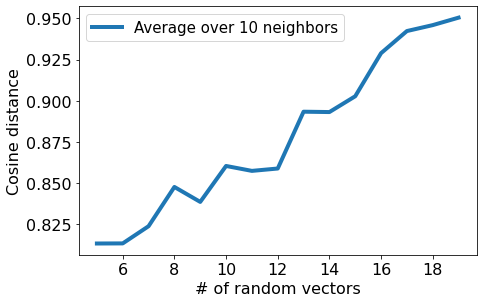

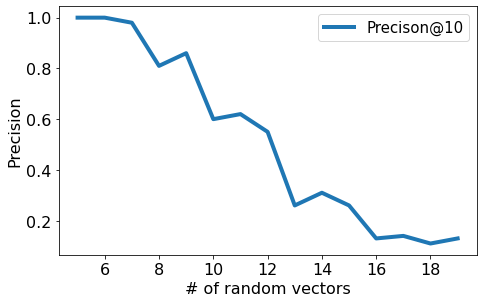

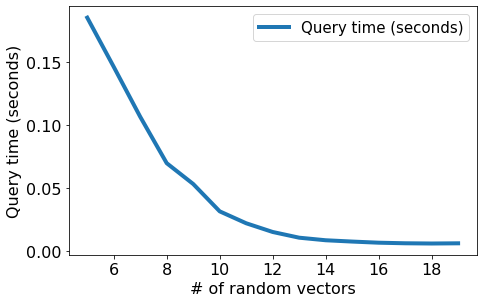

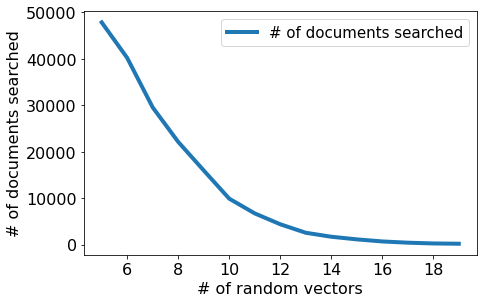

In [191]:
plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(average_distance[i]) for i in range(5,20)], linewidth=4, label='Average over 10 neighbors')
plt.xlabel('# of random vectors')
plt.ylabel('Cosine distance')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(precision[i]) for i in range(5,20)], linewidth=4, label='Precison@10')
plt.xlabel('# of random vectors')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(query_time[i]) for i in range(5,20)], linewidth=4, label='Query time (seconds)')
plt.xlabel('# of random vectors')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(num_candidates_history[i]) for i in range(5,20)], linewidth=4,
         label='# of documents searched')
plt.xlabel('# of random vectors')
plt.ylabel('# of documents searched')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

We see a similar trade-off between quality and performance: as the number of random vectors increases, the query time goes down as each bin contains fewer documents on average, but on average the neighbors are likewise placed farther from the query. On the other hand, when using a small enough number of random vectors, LSH becomes very similar brute-force search: Many documents appear in a single bin, so searching the query bin alone covers a lot of the corpus; then, including neighboring bins might result in searching all documents, just as in the brute-force approach.